# EECS 498-007/598-005 Assignment 5-2: Two-Stage Object Detector - Faster R-CNN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

# Two-Stage Object Detector
In this exercise you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules, Region Proposal Networks (RPN) and Fast R-CNN. We will later use it to train a model that can detect objects on novel images and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-sehstztr
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-sehstztr
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=af5d2ae14b7a937929683585b0bf73cf0bda24ee39edef730d6d357de912c957
  Stored in directory: /tmp/pip-ephem-wheel-cache-fvr_hsk1/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks, \
                    fix_random_seed, rel_error
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 37.01 MiB/s, done.
Resolving deltas: 100% (321/321), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [3]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [4]:
##### Utilities from previous project

In [5]:
def nms(boxes, scores, iou_threshold=0.5, topk=None):
  """
  Non-maximum suppression removes overlapping bounding boxes.

  Inputs:
  - boxes: top-left and bottom-right coordinate values of the bounding boxes
    to perform NMS on, of shape Nx4
  - scores: scores for each one of the boxes, of shape N
  - iou_threshold: discards all overlapping boxes with IoU > iou_threshold; float
  - topk: If this is not None, then return only the topk highest-scoring boxes.
    Otherwise if this is None, then return all boxes that pass NMS.

  Outputs:
  - keep: torch.long tensor with the indices of the elements that have been
    kept by NMS, sorted in decreasing order of scores; of shape [num_kept_boxes]
  """

  if (not boxes.numel()) or (not scores.numel()):
    return torch.zeros(0, dtype=torch.long)

  keep = None
  #############################################################################
  # TODO: Implement non-maximum suppression which iterates the following:     #
  #       1. Select the highest-scoring box among the remaining ones,         #
  #          which has not been chosen in this step before                    #
  #       2. Eliminate boxes with IoU > threshold                             #
  #       3. If any boxes remain, GOTO 1                                      #
  #       Your implementation should not depend on a specific device type;    #
  #       you can use the device of the input if necessary.                   #
  # HINT: You can refer to the torchvision library code:                      #
  #   github.com/pytorch/vision/blob/master/torchvision/csrc/cpu/nms_cpu.cpp  #
  #############################################################################
  # Replace "pass" statement with your code
  keep = []
  indeces = torch.argsort(scores, descending=True)
  areas = torch.prod(boxes[:, 2:] - boxes[:, :2], dim=1)
  while indeces.size()[0] > 0:
    # still left
    idx = indeces[0]
    # 1) 
    max_box = boxes[idx] # current max
    keep.append(idx)
    tl = torch.max(max_box[:2], boxes[indeces][:, :2]) #top left coordinates 
    br = torch.min(max_box[2:], boxes[indeces][:, 2:]) #bottom right coordinates 
    intersect = torch.prod(br - tl, dim=1) * (tl < br).all(dim=1) #intersection 
    a = areas[idx] # (1, )
    b = areas #(N, 1)
    iou = torch.div(intersect, a + b[indeces] - intersect).squeeze() #(N, )
    #2) 
    left = torch.where(iou <= iou_threshold)
    indeces = indeces[left]

  #3) 
  if topk is None:
    pass
  else:
    keep = keep[:topk]
  keep = torch.tensor(keep, **to_long_cuda).to(scores.device)
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return keep

In [6]:
def GenerateProposal(anchors, offsets, method='YOLO'):
  """
  Proposal generator.

  Inputs:
  - anchors: Anchor boxes, of shape (B, A, H', W', 4). Anchors are represented
    by the coordinates of their top-left and bottom-right corners.
  - offsets: Transformations of shape (B, A, H', W', 4) that will be used to
    convert anchor boxes into region proposals. The transformation
    offsets[b, a, h, w] = (tx, ty, tw, th) will be applied to the anchor
    anchors[b, a, h, w]. For YOLO, assume that tx and ty are in the range
    (-0.5, 0.5).
  - method: Which transformation formula to use, either 'YOLO' or 'FasterRCNN'
  
  Outputs:
  - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
    coordinates of their top-left and bottom-right corners. Applying the
    transform offsets[b, a, h, w] to the anchor [b, a, h, w] should give the
    proposal proposals[b, a, h, w].
  
  """
  assert(method in ['YOLO', 'FasterRCNN'])
  proposals = None
  ##############################################################################
  # TODO: Given anchor coordinates and the proposed offset for each anchor,    #
  # compute the proposal coordinates using the transformation formulas above.  #
  ##############################################################################
  # Replace "pass" statement with your code
  proposals = torch.zeros_like(offsets)
  anchor_tfs = torch.zeros_like(anchors)
  #width and height of bounding box 
  anchor_tfs[:,:,:,:,2:] = anchors[:,:,:,:,2:] - anchors[:,:,:,:,:2]
  #middle pose without specific YOLO/RCNN transforms 
  anchor_tfs[:,:,:,:,:2] = (anchors[:,:,:,:,2:] + anchors[:,:,:,:,:2])/2
  anchor_tfs_out = anchor_tfs.clone()
  if method == "YOLO" : 
    anchor_tfs_out[:,:,:,:,:2] = anchor_tfs[:,:,:,:,:2] + offsets[:,:,:,:,:2]
  elif method == "FasterRCNN" : 
    anchor_tfs_out[:,:,:,:,:2] = anchor_tfs[:,:,:,:,:2] + offsets[:,:,:,:,:2] * anchor_tfs[:,:,:,:,2:]
  else : 
    raise NotImplementedError
  
  anchor_tfs_out[:,:,:,:,2:] = anchor_tfs[:,:,:,:,2:] * torch.exp(offsets[:,:,:,:,2:]) 
  proposals[:,:,:,:,:2] = anchor_tfs_out[:,:,:,:,:2] - (anchor_tfs_out[:,:,:,:,2:]/2 )
  proposals[:,:,:,:,2:] = anchor_tfs_out[:,:,:,:,:2] + (anchor_tfs_out[:,:,:,:,2:]/2 )

  
  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################

  return proposals

In [7]:
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).

  Inputs:
  - batch_size, B
  - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
  - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
  - W' and H' are always 7 in our case while w and h might vary.
  
  Outputs:
  grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid

In [8]:
def GenerateAnchor(anc, grid):
  """
  Anchor generator.

  Inputs:
  - anc: Tensor of shape (A, 2) giving the shapes of anchor boxes to consider at
    each point in the grid. anc[a] = (w, h) gives the width and height of the
    a'th anchor shape.
  - grid: Tensor of shape (B, H', W', 2) giving the (x, y) coordinates of the
    center of each feature from the backbone feature map. This is the tensor
    returned from GenerateGrid.
  
  Outputs:
  - anchors: Tensor of shape (B, A, H', W', 4) giving the positions of all
    anchor boxes for the entire image. anchors[b, a, h, w] is an anchor box
    centered at grid[b, h, w], whose shape is given by anc[a]; we parameterize
    boxes as anchors[b, a, h, w] = (x_tl, y_tl, x_br, y_br), where (x_tl, y_tl)
    and (x_br, y_br) give the xy coordinates of the top-left and bottom-right
    corners of the box.
  """
  anchors = None
  ##############################################################################
  # TODO: Given a set of anchor shapes and a grid cell on the activation map,  #
  # generate all the anchor coordinates for each image. Support batch input.   #
  ##############################################################################
  # Replace "pass" statement with your code
  A, _ = anc.shape 
  B,H,W,_ = grid.shape 
  anchors = torch.zeros((B,A,H,W,4),dtype=anc.dtype,device=anc.device)
  for a in range(A) : 
    anchors[:,a,:,:,0] = grid[:,:,:,0] - anc[a,0]/2
    anchors[:,a,:,:,1] = grid[:,:,:,1] - anc[a,1]/2
    anchors[:,a,:,:,2] = grid[:,:,:,0] + anc[a,0]/2
    anchors[:,a,:,:,3] = grid[:,:,:,1] + anc[a,1]/2

  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################

  return anchors

In [9]:
def IoU(proposals, bboxes):
  """
  Compute intersection over union between sets of bounding boxes.

  Inputs:
  - proposals: Proposals of shape (B, A, H', W', 4)
  - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
    Each ground-truth box is represented as tuple (x_lr, y_lr, x_rb, y_rb, class).
    If image i has fewer than N boxes, then bboxes[i] will be padded with extra
    rows of -1.
  
  Outputs:
  - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
    the IoU between one element of proposals[b] and bboxes[b, n].

  For this implementation you DO NOT need to filter invalid proposals or boxes;
  in particular you don't need any special handling for bboxxes that are padded
  with -1.
  """
  iou_mat = None
  ##############################################################################
  # TODO: Compute the Intersection over Union (IoU) on proposals and GT boxes. #
  # No need to filter invalid proposals/bboxes (i.e., allow region area <= 0). #
  # You need to ensure your implementation is efficient (no for loops).        #
  # HINT:                                                                      #
  # IoU = Area of Intersection / Area of Union, where
  # Area of Union = Area of Proposal + Area of BBox - Area of Intersection     #
  # and the Area of Intersection can be computed using the top-left corner and #
  # bottom-right corner of proposal and bbox. Think about their relationships. #
  ##############################################################################
  # Replace "pass" statement with your code
  B, A, H, W, _ = proposals.shape
  proposals = proposals.reshape(B,A*W*H,4)
  tl = torch.max(proposals[:,:,:2].unsqueeze(2),bboxes[:,:,:2].unsqueeze(1))
  br = torch.min(proposals[:,:,2:].unsqueeze(2),bboxes[:,:,2:4].unsqueeze(1))
  intersection = torch.prod(br-tl,dim=3) 
  intersection = intersection * (tl < br).all(dim=3)
  a = torch.prod(bboxes[:,:,2:4] - bboxes[:,:,:2],dim=2) #area of proposal 
  b = torch.prod(proposals[:,:,2:] - proposals[:,:,:2],dim=2) #area of bbox, still need to subtract intersect for total outcome of AoU
  iou_mat = torch.div(intersection,a.unsqueeze(1) + b.unsqueeze(2) - intersection)

  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################
  return iou_mat

In [10]:
def ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3, method='FasterRCNN'):
  """
  Determine the activated (positive) and negative anchors for model training.

  For YOLO - A grid cell is responsible for predicting a GT box if the center of
  the box falls into that cell.
  Implementation details: First compute manhattan distance between grid cell centers
  (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
  perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
  responsible for GT boxes (convert to x and y). Among all the anchors associated with
  the activate grids, the anchor with the largest IoU with the GT box is responsible to
  predict (regress to) the GT box.
  Note: One anchor might match multiple GT boxes.

  For Faster R-CNN - Positive anchors are defined Any of the two
  (i) the anchor/anchors with the highest IoU overlap with a GT box, or
  (ii) an anchor that has an IoU overlap higher than 0.7 with any GT box.
  Note: One anchor can match at most one GT box (the one with the largest IoU overlapping).

  For both - We assign a negative label to a anchor if its IoU ratio is lower than
  a threshold value for all GT boxes. Anchors that are neither positive nor negative
  do not contribute to the training objective.

  Main steps include:
  i) Decide activated and negative anchors based on the IoU matrix.
  ii) Compute GT confidence score/offsets/object class on the positive proposals.
  iii) Compute GT confidence score on the negative proposals.
  
  Inputs:
  - anchors: Anchor boxes, of shape BxAxH’xW’x4
  - bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
            5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
  - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
  - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
  - pos_thresh: Positive threshold value
  - neg_thresh: Negative threshold value
  - method: Switch between 'YOLO' mode and 'FasterRCNN' mode
  
  Outputs:
  - activated_anc_ind: Index on activated anchors, of shape M, where M indicates the 
                       number of activated anchors
  - negative_anc_ind: Index on negative anchors, of shape M
  - GT_conf_scores: GT IoU confidence scores on activated anchors, of shape M
  - GT_offsets: GT offsets on activated anchors, of shape Mx4. They are denoted as
                \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
  - GT_class: GT class category on activated anchors, essentially indexed from bboxes[:, :, 4],
              of shape M
  - activated_anc_coord: Coordinates on activated anchors (mainly for visualization purposes)
  - negative_anc_coord: Coordinates on negative anchors (mainly for visualization purposes)
  """
  
  assert(method in ['FasterRCNN', 'YOLO'])

  B, A, h_amap, w_amap, _ = anchors.shape
  N = bboxes.shape[1]

  # activated/positive anchors
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
  if method == 'FasterRCNN':
    max_iou_per_box = iou_mat.max(dim=1, keepdim=True)[0]
    activated_anc_mask = (iou_mat == max_iou_per_box) & (max_iou_per_box > 0)
    activated_anc_mask |= (iou_mat > pos_thresh) # using the pos_thresh condition as well
    # if an anchor matches multiple GT boxes, choose the box with the largest iou
    activated_anc_mask = activated_anc_mask.max(dim=-1)[0] # Bx(AxH’xW’)
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)

    # GT conf scores
    GT_conf_scores = max_iou_per_anc[activated_anc_mask] # M

    # GT class
    box_cls = bboxes[:, :, 4].view(B, 1, N).expand((B, A*h_amap*w_amap, N))
    GT_class = torch.gather(box_cls, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1) # M
    GT_class = GT_class[activated_anc_mask].long()

    bboxes_expand = bboxes[:, :, :4].view(B, 1, N, 4).expand((B, A*h_amap*w_amap, N, 4))
    bboxes = torch.gather(bboxes_expand, -2, max_iou_per_anc_ind.unsqueeze(-1) \
      .unsqueeze(-1).expand(B, A*h_amap*w_amap, 1, 4)).view(-1, 4)
    bboxes = bboxes[activated_anc_ind]
  else:
    bbox_mask = (bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
    bbox_centers = (bboxes[:, :, 2:4] - bboxes[:, :, :2]) / 2. + bboxes[:, :, :2] # BxNx2

    mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
    min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
    grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

    reshaped_iou_mat = iou_mat.view(B, A, -1, N)
    anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
    anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
    activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
    activated_anc_mask &= bbox_mask.unsqueeze(1)
    
    # one anchor could match multiple GT boxes
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
    GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
    bboxes = bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
    GT_class = bboxes[:, 4].long()
    bboxes = bboxes[:, :4]
    activated_anc_ind = (activated_anc_ind // activated_anc_mask.shape[-1]).long()

  print('number of pos proposals: ', activated_anc_ind.shape[0])
  activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]

  # GT offsets
  # bbox and anchor coordinates are x_tl, y_tl, x_br, y_br
  # offsets are t_x, t_y, t_w, t_h
  wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) \
    / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))

  xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - \
    activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

  if method == "FasterRCNN":
    xy_offsets /= (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2])
  else:
    assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
      "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
      torch.max(torch.abs(xy_offsets)))

  GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

  # negative anchors
  negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]
  
  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

## Import functions from previous notebook
Like what you have seen in the previous assignment, this notebook will re-use some pieces of code that you implemented in the previous notebook.

In order to do this, you will need the **Google Drive file ID** of your completed notebook `single_stage_detector_yolo.ipynb`. You can find the this file ID by doing the following:
1. Make sure you have saved your completed `single_stage_detector_yolo.ipynb` notebook to your own Google Drive
2. Open you finished `single_stage_detector_yolo.ipynb` notebook in Colab.
3. Click the "Share" button at the top of the screen
4. Copy the "Notebook link" and paste it in the following cell, assigning it to the `YOLO_NOTEBOOK_LINK` variable

**Important:** If you modify the implementations of any functions in your `single_stage_detector_yolo.ipynb` notebook, **they will not automatically be propagated to this notebook**. For changes to `single_stage_detector_yolo.ipynb` to be propagated to this notebook, you will need to:
1. Make sure that you save your modified `single_stage_detector_yolo.ipynb` notebook (File > Save)
2. Restart the runtime of this notebook (Runtime > Restart Runtime)
3. Rerun all cells in this notebook (in particular the import cell below)

## Load PASCAL VOC 2007 data
As in the previous notebook, we will use the PASCAL VOC 2007 dataset to train our object detection system.

As in the previous notebook, we will subsample the dataset and wrap it in a DataLoader that can form minibatches for us.

In [12]:
def get_pascal_voc2007_data(image_root, split='train'):
  """
  Use torchvision.datasets
  https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCDetection
  """
  from torchvision import datasets

  train_dataset = datasets.VOCDetection(image_root, year='2007', image_set=split,
                                    download=True)
  
  return train_dataset

In [16]:


def pascal_voc2007_loader(dataset, batch_size, num_workers=0):
  """
  Data loader for Pascal VOC 2007.
  https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
  """
  from torch.utils.data import DataLoader
  # turn off shuffle so we can index the original image
  train_loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False, pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=voc_collate_fn)
  return train_loader


class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}


from torchvision import transforms

def voc_collate_fn(batch_lst, reshape_size=224):
    preprocess = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    
    batch_size = len(batch_lst)
    
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)
    
    max_num_box = max(len(batch_lst[i][1]['annotation']['object']) \
                      for i in range(batch_size))

    box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)
    w_list = []
    h_list = []
    img_id_list = []
    
    for i in range(batch_size):
      img, ann = batch_lst[i]
      w_list.append(img.size[0]) # image width
      h_list.append(img.size[1]) # image height
      img_id_list.append(ann['annotation']['filename'])
      img_batch[i] = preprocess(img)
      all_bbox = ann['annotation']['object']
      if type(all_bbox) == dict: # inconsistency in the annotation file
        all_bbox = [all_bbox]
      for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_batch[i][bbox_idx] = torch.Tensor([float(bbox['xmin']), float(bbox['ymin']),
          float(bbox['xmax']), float(bbox['ymax']), class_to_idx[obj_cls]])
    
    h_batch = torch.tensor(h_list)
    w_batch = torch.tensor(w_list)

    return img_batch, box_batch, w_batch, h_batch, img_id_list



In [13]:
# uncomment below to use the mirror link if the original link is broken
#!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
train_dataset = get_pascal_voc2007_data('/content', 'train')
val_dataset = get_pascal_voc2007_data('/content', 'val')

Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar


In [17]:
class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

In [18]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [19]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('Resized train images shape: ', img[0].shape)
print('Padded annotation tensor shape: ', ann[0].shape)
print(ann[0])
print('Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')
print('Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)')

Resized train images shape:  torch.Size([3, 224, 224])
Padded annotation tensor shape:  torch.Size([6, 5])
tensor([[156.,  97., 351., 270.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])
Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).
Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)


In [22]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred of pixels in
  width/height while the activation map is of size 7x7.

  Input:
  - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
  - w_pixel: Number of pixels in the width side of the original image, of shape B
  - h_pixel: Number of pixels in the height side of the original image, of shape B
  - w_amap: Number of pixels in the width side of the activation map, scalar
  - h_amap: Number of pixels in the height side of the activation map, scalar
  - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

  Output:
  - resized_bbox: Resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
  
  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox

In [25]:
def data_visualizer(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image. Support both GT box input and proposal input.
  
  Input:
  - img: PIL Image input
  - idx_to_class: Mapping from the index (0-19) to the class name
  - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
          the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
  - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
          N' is the number of predicted boxes, 6 indicates
          (x_tl, y_tl, x_br, y_br, class, object confidence score)
  """

  img_copy = np.array(img).astype('uint8')

  if bbox is not None:
    for bbox_idx in range(bbox.shape[0]):
      one_bbox = bbox[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (255, 0, 0), 2)
      if bbox.shape[1] > 4: # if class info provided
        obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
        cv2.putText(img_copy, '%s' % (obj_cls),
                  (one_bbox[0], one_bbox[1]+15),
                  cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  if pred is not None:
    for bbox_idx in range(pred.shape[0]):
      one_bbox = pred[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (0, 255, 0), 2)
      
      if pred.shape[1] > 4: # if class and conf score info provided
        obj_cls = idx_to_class[pred[bbox_idx][4].item()]
        conf_score = pred[bbox_idx][5].item()
        cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                    (one_bbox[0], one_bbox[1]+15),
                    cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

## Visualize PASCAL VOC 2007
Sample a couple of images and GT boxes.

In [26]:
# default examples for visualization
fix_random_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.tensor(w_list, **to_float_cuda)
h_list = torch.tensor(h_list, **to_float_cuda)
box_list = torch.tensor(box_list, **to_float_cuda)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


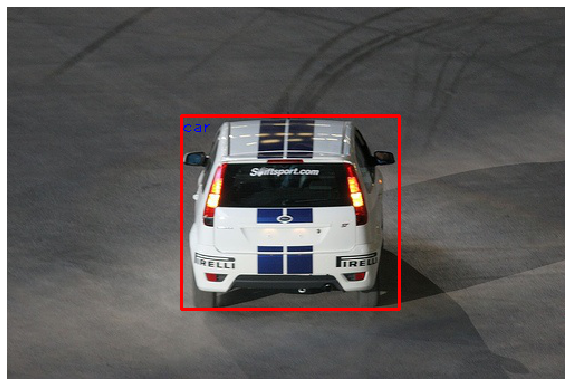

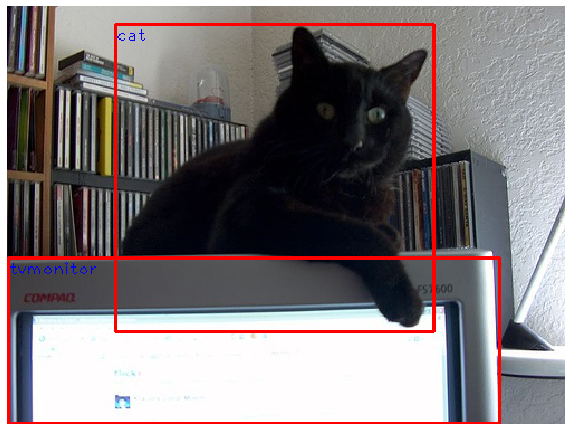

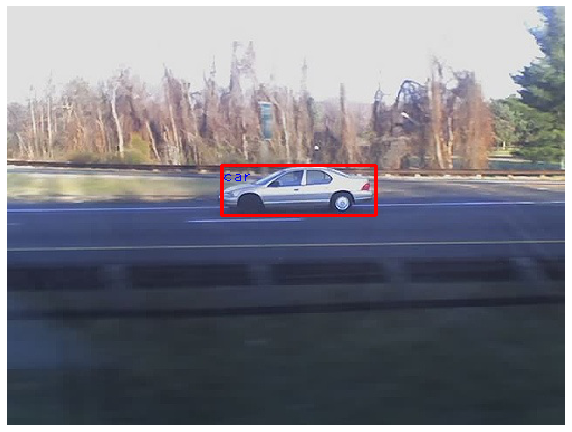

In [27]:
# visualize GT boxes
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  data_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Region Proposal Networks (RPN)
The first stage in a Faster R-CNN object detector is the *Region Proposal Network (RPN)*. The RPN classifies a set of anchors as either containing an object or not, and also regresses from the position of the anchor box to a region proposal.

The RPN is very similar to the single-stage detector we built in the previous notebook, except that it will not predict classification scores. We can therefore reuse many of the functions from the previous notebook in order to implement the RPN.

## Anchor
We will use the exact same set of anchors as in the single-stage detector from the previous notebook.

In [28]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], **to_float_cuda)
print(anchor_list.shape)

torch.Size([9, 2])


We can implement anchor generation and matching to ground-truth by reusing the `GenerateGrid`, `GenerateAnchor`, `IoU`, and `ReferenceOnActivatedAnchors` functions from the previous notebook.

Run the following to check the implementation from A5-1 (with your IoU function). You should see errors on the order of 1e-7 or less.

In [29]:
fix_random_seed(0)

grid_list = GenerateGrid(w_list.shape[0])
anc_list = GenerateAnchor(anchor_list, grid_list)
iou_mat = IoU(anc_list, resized_box_list)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat)

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.71128041, 0.70029843,
                                        0.75670898, 0.76044953, 0.37116671, 0.37116671], **to_float_cuda)
expected_GT_offsets = torch.tensor([[ 0.01633334,  0.11911901, -0.09431065,  0.19244696],
                                    [-0.03675002,  0.09324861, -0.00250307,  0.25213102],
                                    [-0.03675002, -0.15675139, -0.00250307,  0.25213102],
                                    [-0.02940002,  0.07459889, -0.22564663,  0.02898745],
                                    [ 0.11879997,  0.03208542,  0.20863886, -0.07974572],
                                    [-0.08120003,  0.03208542,  0.20863886, -0.07974572],
                                    [ 0.07699990,  0.28533328, -0.03459148, -0.86750042],
                                    [ 0.07699990, -0.21466672, -0.03459148, -0.86750042]], **to_float_cuda)
expected_GT_class = torch.tensor([ 6,  7,  7,  7, 19, 19,  6,  6], **to_long_cuda)
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

number of pos proposals:  8
conf scores error:  0.0
offsets error:  7.441442448907765e-07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


RuntimeError: ignored

********************************************************************************
Activated (positive) anchors:
1 activated anchors!


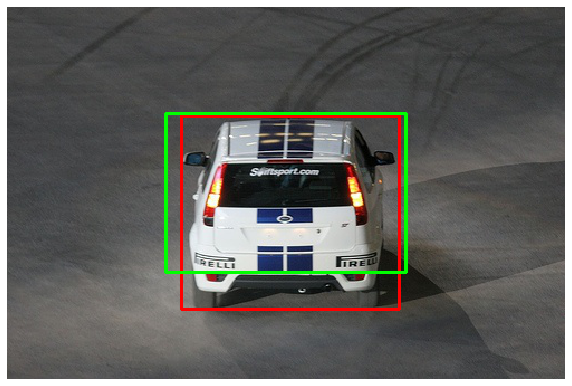

5 activated anchors!


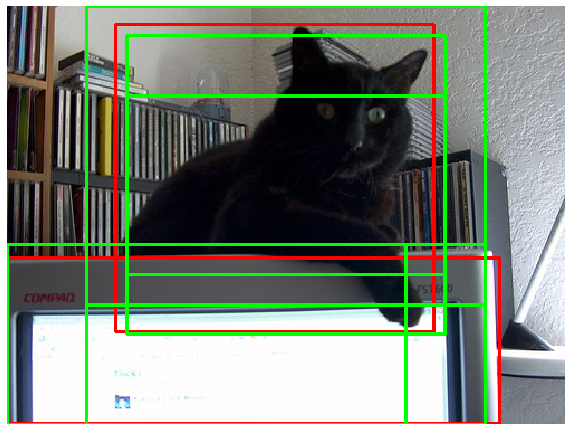

2 activated anchors!


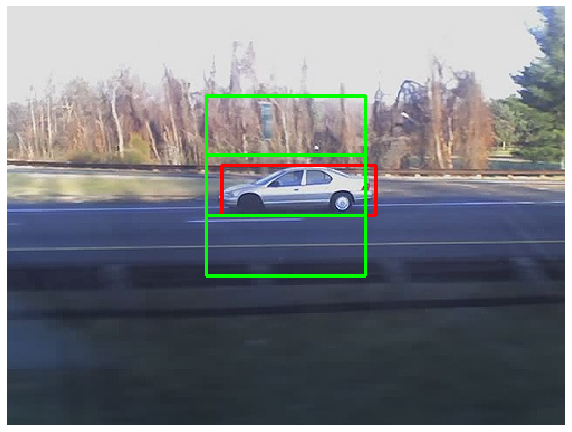

********************************************************************************
Negative anchors:
3 negative anchors!


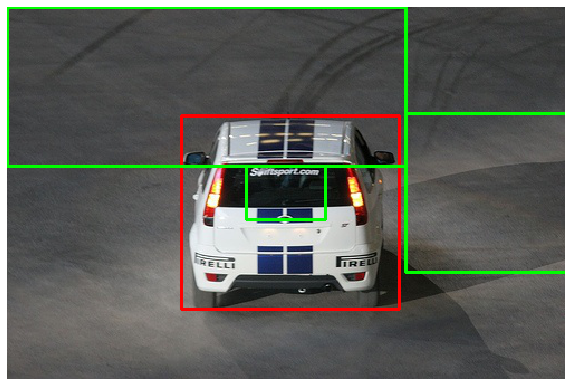

2 negative anchors!


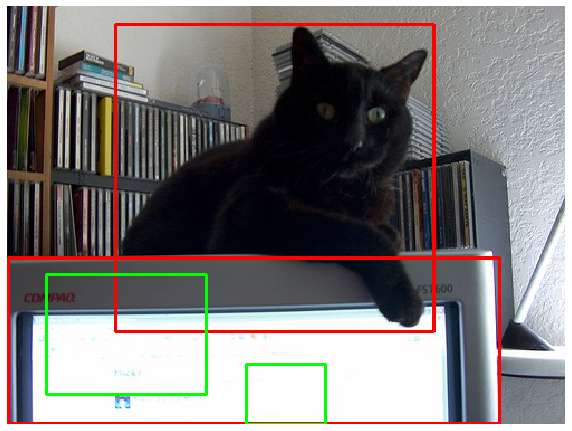

3 negative anchors!


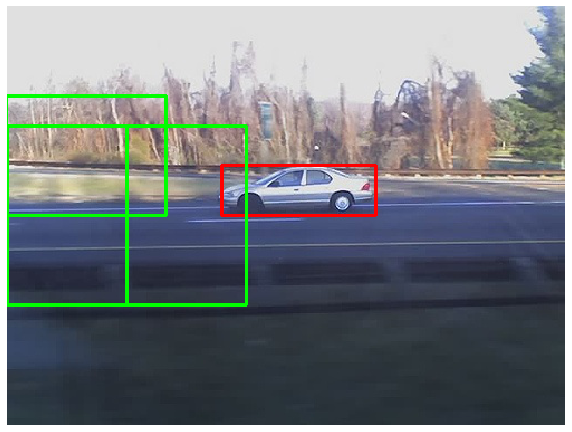

In [30]:
# visualize the activated anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

## Proposal module
Similar to the Prediction Networks in A5-1, but for RPN you only need to predict the object proposal scores (from the *cls* layer) and bounding box offsets (from the *reg* layer), all of which are class-agnostic.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

Note that here $k$ is essentially $A$. Image credit: Ren et al, "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks", NeurIPS 2015, https://arxiv.org/abs/1506.01497

In [32]:
class ProposalModule(nn.Module):
  def __init__(self, in_dim, hidden_dim=256, num_anchors=9, drop_ratio=0.3):
    super().__init__()

    assert(num_anchors != 0)
    self.num_anchors = num_anchors
    ##############################################################################
    # TODO: Define the region proposal layer - a sequential module with a 3x3    #
    # conv layer, followed by a Dropout (p=drop_ratio), a Leaky ReLU and         #
    # a 1x1 conv.                                                                #
    # HINT: The output should be of shape Bx(Ax6)x7x7, where A=self.num_anchors. #
    #       Determine the padding of the 3x3 conv layer given the output dim.    #
    ##############################################################################
    # Replace "pass" statement with your code
    self.conv1 = nn.Conv2d(in_dim,hidden_dim,3,padding=1)
    self.drop = nn.Dropout(p=drop_ratio)
    self.activation = nn.LeakyReLU()
    A = self.num_anchors
    self.conv2 = nn.Conv2d(hidden_dim,A*6,1)

    self.cnn = nn.Sequential(
        self.conv1,
        self.drop,
        self.activation,
        self.conv2
    )

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    Inputs:
    - anchor_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A anchors at each point in an H x W grid.
    - anchor_idx: int64 Tensor of shape (M,) giving anchor indices to extract

    Returns:
    - extracted_anchors: Tensor of shape (M, D) giving anchor data for each
      of the anchors specified by anchor_idx.
    """
    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_anchors = anchor_data[anchor_idx]
    return extracted_anchors

  def forward(self, features, pos_anchor_coord=None, \
              pos_anchor_idx=None, neg_anchor_idx=None):
    """
    Run the forward pass of the proposal module.

    Inputs:
    - features: Tensor of shape (B, in_dim, H', W') giving features from the
      backbone network.
    - pos_anchor_coord: Tensor of shape (M, 4) giving the coordinates of
      positive anchors. Anchors are specified as (x_tl, y_tl, x_br, y_br) with
      the coordinates of the top-left corner (x_tl, y_tl) and bottom-right
      corner (x_br, y_br). During inference this is None.
    - pos_anchor_idx: int64 Tensor of shape (M,) giving the indices of positive
      anchors. During inference this is None.
    - neg_anchor_idx: int64 Tensor of shape (M,) giving the indicdes of negative
      anchors. During inference this is None.

    The outputs from this module are different during training and inference.
    
    During training, pos_anchor_coord, pos_anchor_idx, and neg_anchor_idx are
    all provided, and we only output predictions for the positive and negative
    anchors. During inference, these are all None and we must output predictions
    for all anchors.

    Outputs (during training):
    - conf_scores: Tensor of shape (2M, 2) giving the classification scores
      (object vs background) for each of the M positive and M negative anchors.
    - offsets: Tensor of shape (M, 4) giving predicted transforms for the
      M positive anchors.
    - proposals: Tensor of shape (M, 4) giving predicted region proposals for
      the M positive anchors.

    Outputs (during inference):
    - conf_scores: Tensor of shape (B, A, 2, H', W') giving the predicted
      classification scores (object vs background) for all anchors
    - offsets: Tensor of shape (B, A, 4, H', W') giving the predicted transforms
      for all anchors
    """
    if pos_anchor_coord is None or pos_anchor_idx is None or neg_anchor_idx is None:
      mode = 'eval'
    else:
      mode = 'train'
    conf_scores, offsets, proposals = None, None, None
    ############################################################################
    # TODO: Predict classification scores (object vs background) and transforms#
    # for all anchors. During inference, simply output predictions for all     #
    # anchors. During training, extract the predictions for only the positive  #
    # and negative anchors as described above, and also apply the transforms to#
    # the positive anchors to compute the coordinates of the region proposals. #
    #                                                                          #
    # HINT: You can extract information about specific proposals using the     #
    # provided helper function self._extract_anchor_data.                      #
    # HINT: You can compute proposal coordinates using the GenerateProposal    #
    # function from the previous notebook.                                     #
    ############################################################################
    # Replace "pass" statement with your code
    A = self.num_anchors 
    B, _ , H, W = features.shape 
    feats = self.cnn(features)
    feats = feats.view(B,A,6,H,W)
    
    if mode == "train" : 
      M, _ = pos_anchor_coord.shape 
      anchor_pos = self._extract_anchor_data(feats,pos_anchor_idx) 
      anchor_neg = self._extract_anchor_data(feats,neg_anchor_idx)
      offsets = anchor_pos[:, 2:] 
      conf_scores = torch.cat((anchor_pos[:,:2], anchor_neg[:,:2]), dim=0) 
      proposals = GenerateProposal(pos_anchor_coord.reshape(M, 1, 1, 1, 4), offsets.reshape(M, 1, 1, 1, 4), method='FasterRCNN')
      proposals = proposals.squeeze()

    elif mode == "eval" :
       offsets = feats[:, :, 2:, :, :]
       conf_scores = feats[:, :, :2, :, :]
      
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    if mode == 'train':
      return conf_scores, offsets, proposals
    elif mode == 'eval':
      return conf_scores, offsets

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [33]:
# sanity check
fix_random_seed(0)
prop_module = ProposalModule(1280, drop_ratio=0).to(**to_float_cuda)
features = torch.linspace(-10., 10., steps=3*1280*7*7, **to_float_cuda).view(3, 1280, 7, 7)
conf_scores, offsets, proposals = prop_module(features, activated_anc_coord, \
              pos_anchor_idx=activated_anc_ind, neg_anchor_idx=negative_anc_ind)

expected_conf_scores = torch.tensor([[-0.50843990,  2.62025023],
                                     [-0.55775326, -0.29983672],
                                     [-0.55796617, -0.30000290],
                                     [ 0.17819080, -0.42211828],
                                     [-0.51439995, -0.47708601],
                                     [-0.51439744, -0.47703803],
                                     [ 0.63225138,  2.71269488],
                                     [ 0.63224381,  2.71290708]], **to_float_cuda)
expected_offsets = torch.tensor([[ 1.62754285,  1.35253453, -1.85451591, -1.77882397],
                                 [-0.33651856, -0.14402901, -0.07458937, -0.27201492],
                                 [-0.33671042, -0.14398587, -0.07479107, -0.27199429],
                                 [ 0.06847382,  0.21062726,  0.09334904, -0.02446130],
                                 [ 0.16506940, -0.30296192,  0.29626080,  0.32173073],
                                 [ 0.16507357, -0.30302414,  0.29625297,  0.32169008],
                                 [ 1.59992146, -0.75236654,  1.66449440,  2.05138564],
                                 [ 1.60008609, -0.75249159,  1.66474164,  2.05162382]], **to_float_cuda)

print('conf scores error: ', rel_error(conf_scores[:8], expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))

conf scores error:  1.3915323506807908e-06
offsets error:  4.896412974630948e-06


## Loss Function
The confidence score regression loss is for both activated/negative anchors while the bounding box regression loss loss is for activated anchors only.

### Confidence score regression


In [34]:
def ConfScoreRegression(conf_scores, batch_size):
  """
  Binary cross-entropy loss

  Inputs:
  - conf_scores: Predicted confidence scores, of shape (2M, 2). Assume that the
    first M are positive samples, and the last M are negative samples.

  Outputs:
  - conf_score_loss: Torch scalar
  """
  # the target conf_scores for positive samples are ones and negative are zeros
  M = conf_scores.shape[0] // 2
  GT_conf_scores = torch.zeros_like(conf_scores)
  GT_conf_scores[:M, 0] = 1.
  GT_conf_scores[M:, 1] = 1.

  conf_score_loss = F.binary_cross_entropy_with_logits(conf_scores, GT_conf_scores, \
                                     reduction='sum') * 1. / batch_size
  return conf_score_loss

### Bounding box regression

In [35]:
def BboxRegression(offsets, GT_offsets, batch_size):
  """"
  Use SmoothL1 loss as in Faster R-CNN

  Inputs:
  - offsets: Predicted box offsets, of shape (M, 4)
  - GT_offsets: GT box offsets, of shape (M, 4)
  
  Outputs:
  - bbox_reg_loss: Torch scalar
  """
  bbox_reg_loss = F.smooth_l1_loss(offsets, GT_offsets, reduction='sum') * 1. / batch_size
  return bbox_reg_loss

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [36]:
conf_loss = ConfScoreRegression(conf_scores, features.shape[0])
reg_loss = BboxRegression(offsets, GT_offsets, features.shape[0])
print('conf loss: {:.4f}, reg loss: {:.4f}'.format(conf_loss, reg_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data], **to_float_cuda)
expected_loss = torch.tensor([8.55673981, 5.10593748], **to_float_cuda)

print('loss error: ', rel_error(loss_all, expected_loss))

conf loss: 8.5567, reg loss: 5.1059
loss error:  2.801662617457623e-07


## RPN module
Implement Region Proposal Network. Should resemble the `SingleStageDetector` module from A5-1, but without the class prediction.

In [61]:
import pdb 
class RPN(nn.Module):
  def __init__(self):
    super().__init__()

    # READ ONLY
    self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]])
    self.feat_extractor = FeatureExtractor()
    self.prop_module = ProposalModule(1280, num_anchors=self.anchor_list.shape[0])

  def forward(self, images, bboxes, output_mode='loss'):
    """
    Training-time forward pass for the Region Proposal Network.

    Inputs:
    - images: Tensor of shape (B, 3, 224, 224) giving input images
    - bboxes: Tensor of ground-truth bounding boxes, returned from the DataLoader
    - output_mode: One of 'loss' or 'all' that determines what is returned:
      If output_mode is 'loss' then the output is:
      - total_loss: Torch scalar giving the total RPN loss for the minibatch
      If output_mode is 'all' then the output is:
      - total_loss: Torch scalar giving the total RPN loss for the minibatch
      - pos_conf_scores: Tensor of shape (M, 1) giving the object classification
        scores (object vs background) for the positive anchors
      - proposals: Tensor of shape (M, 4) giving the coordiantes of the region
        proposals for the positive anchors
      - features: Tensor of features computed from the backbone network
      - GT_class: Tensor of shape (M,) giving the ground-truth category label
        for the positive anchors.
      - pos_anchor_idx: Tensor of shape (M,) giving indices of positive anchors
      - neg_anchor_idx: Tensor of shape (M,) giving indices of negative anchors
      - anc_per_image: Torch scalar giving the number of anchors per image.
    
    Outputs: See output_mode

    HINT: The function ReferenceOnActivatedAnchors from the previous notebook
    can compute many of these outputs -- you should study it in detail:
    - pos_anchor_idx (also called activated_anc_ind)
    - neg_anchor_idx (also called negative_anc_ind)
    - GT_class
    """
    # weights to multiply to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 5 # for offsets

    assert output_mode in ('loss', 'all'), 'invalid output mode!'
    total_loss = None
    conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img = \
      None, None, None, None, None, None
    ##############################################################################
    # TODO: Implement the forward pass of RPN.                                   #
    # A few key steps are outlined as follows:                                   #
    # i) Image feature extraction,                                               #
    # ii) Grid and anchor generation,                                            #
    # iii) Compute IoU between anchors and GT boxes and then determine activated/#
    #      negative anchors, and GT_conf_scores, GT_offsets, GT_class,           #
    # iv) Compute conf_scores, offsets, proposals through the region proposal    #
    #     module                                                                 #
    # v) Compute the total_loss for RPN which is formulated as:                  #
    #    total_loss = w_conf * conf_loss + w_reg * reg_loss,                     #
    #    where conf_loss is determined by ConfScoreRegression, w_reg by          #
    #    BboxRegression. Note that RPN does not predict any class info.          #
    #    We have written this part for you which you've already practiced earlier#
    # HINT: Do not apply thresholding nor NMS on the proposals during training   #
    #       as positive/negative anchors have been explicitly targeted.          #
    ##############################################################################
    # Replace "pass" statement with your code
    B, _ , H , W = images.shape  
    # 1) 
    feats = self.feat_extractor(images)
    # 2) 
    grid_list = GenerateGrid(B)
    anc_list = GenerateAnchor(self.anchor_list.to(grid_list.device, grid_list.dtype), grid_list)  
    #3) 
    iou_mat = IoU(anc_list, bboxes)
    pos_anchor_idx, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, bboxes, grid_list, iou_mat)
    #4) 
    conf_scores, offsets,proposals = self.prop_module(feats,activated_anc_coord,pos_anchor_idx,negative_anc_ind)
    #5) 
    conf_loss = ConfScoreRegression(conf_scores,B)
    reg_loss = BboxRegression(offsets,GT_offsets,B)
    total_loss = w_conf * conf_loss + w_reg * reg_loss

    anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    if output_mode == 'loss':
      return total_loss
    else:
      return total_loss, conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img


  def inference(self, images, thresh=0.5, nms_thresh=0.7, mode='RPN'):
    """
    Inference-time forward pass for the Region Proposal Network.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - thresh: Threshold value on confidence scores. Proposals with a predicted
      object probability above thresh should be kept. HINT: You can convert the
      object score to an object probability using a sigmoid nonlinearity.
    - nms_thresh: IoU threshold for non-maximum suppression
    - mode: One of 'RPN' or 'FasterRCNN' to determine the outputs.

    The region proposal network can output a variable number of region proposals
    per input image. We assume that the input image images[i] gives rise to
    P_i final propsals after thresholding and NMS.

    NOTE: NMS is performed independently per-image!

    Outputs:
    - final_proposals: List of length B, where final_proposals[i] is a Tensor
      of shape (P_i, 4) giving the coordinates of the predicted region proposals
      for the input image images[i].
    - final_conf_probs: List of length B, where final_conf_probs[i] is a
      Tensor of shape (P_i,) giving the predicted object probabilities for each
      predicted region proposal for images[i]. Note that these are
      *probabilities*, not scores, so they should be between 0 and 1.
    - features: Tensor of shape (B, D, H', W') giving the image features
      predicted by the backbone network for each element of images.
      If mode is "RPN" then this is a dummy list of zeros instead.
    """
    assert mode in ('RPN', 'FasterRCNN'), 'invalid inference mode!'

    features, final_conf_probs, final_proposals = None, None, None
    ##############################################################################
    # TODO: Predicting the RPN proposal coordinates `final_proposals` and        #
    # confidence scores `final_conf_probs`.                                     #
    # The overall steps are similar to the forward pass but now you do not need  #
    # to decide the activated nor negative anchors.                              #
    # HINT: Threshold the conf_scores based on the threshold value `thresh`.     #
    # Then, apply NMS to the filtered proposals given the threshold `nms_thresh`.#
    ##############################################################################
    # Replace "pass" statement with your code
    final_conf_probs, final_proposals = [],[]
    # i) Image feature extraction
    features = self.feat_extractor(images)

    # ii) Grid and anchor generation
    batch_size = images.shape[0]
    grid = GenerateGrid(batch_size)
    # anchors = GenerateAnchor(self.anchor_list.cuda(), grid)
    anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid)

    # iii) Compute conf_scores, proposals, class_prob through the prediction network
    conf_scores, offsets = self.prop_module(features) 
    #offsets: (B, A, 4, H', W')
    #conf_scores: (B, A, 2, H', W')
    B,A,_,H,W = conf_scores.shape
    
    offsets = offsets.permute((0,1,3,4,2))
    proposals = GenerateProposal(anchors, offsets, method='FasterRCNN') #proposals:B,A,H,W,4
    # transform
    conf_scores = torch.sigmoid(conf_scores[:,:,0,:,:]) # only look at the 1st confidence score which represent obj_conf
    conf_scores = conf_scores.permute((0,2,3,1)).reshape(batch_size,-1)
    proposals = proposals.permute((0,2,3,1,4)).reshape(batch_size,-1,4)

    with torch.no_grad(): 
      for i in range(batch_size):
        # get proposals, confidence scores for i-th image
        sub_conf_scores = conf_scores[i]
        sub_proposals = proposals[i]
        
        # filter by conf_scores
        mask1 = sub_conf_scores > thresh
        sub_conf_scores = sub_conf_scores[mask1]
        sub_proposals = sub_proposals[mask1,:]
        # filter by nms
        mask2 = nms(sub_proposals, sub_conf_scores, iou_threshold=nms_thresh)
        # append result
        final_proposals.append(sub_proposals[mask2,:])
        final_conf_probs.append(sub_conf_scores[mask2].unsqueeze(1))


     
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    if mode == 'RPN':
      features = [torch.zeros_like(i) for i in final_conf_probs] # dummy class
    return final_proposals, final_conf_probs, features

In [62]:


def DetectionSolver(detector, train_loader, learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, **kwargs):
  """
  Run optimization to train the model.
  """

  # ship model to GPU
  detector.to(**to_float_cuda)

  # optimizer setup
  from torch import optim
  # optimizer = optim.Adam(
  optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  loss_history = []
  detector.train()
  for i in range(num_epochs):
    start_t = time.time()
    for iter_num, data_batch in enumerate(train_loader):
      images, boxes, w_batch, h_batch, _ = data_batch
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      images = images.to(**to_float_cuda)
      resized_boxes = resized_boxes.to(**to_float_cuda)

      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()

      print('(Iter {} / {})'.format(iter_num, len(train_loader)))

    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()



In [63]:
class FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    from torchvision import models
    from torchsummary import summary

    self.mobilenet = models.mobilenet_v2(pretrained=True)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 7 x 7

    for i in self.mobilenet.named_parameters():
      i[1].requires_grad = True # fine-tune all

    if verbose:
      summary(self.mobilenet.cuda(), (3, reshape_size, reshape_size))
  
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x224x224
    
    Outputs:
    - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
    """
    num_img = img.shape[0]
    
    img_prepro = img

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat


## RPN solver
In Faster R-CNN, the RPN is trained jointly with the second-stage network. However, to test our RPN implementation, we will first train just the RPN; this is basically a class-agnostic single-stage detector, that only classifies regions as object or background.

In [64]:
RPNSolver = DetectionSolver # the same solver as in YOLO

## RPN - Overfit small data
First we will overfit the RPN on a small subset of the PASCAL VOC 2007 dataset. After training you should see a loss around or less than 3.0.

lr:  0.001
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 0 / 200) loss: 27.5251 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 1 / 200) loss: 53.8476 time per epoch: 0.2s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 2 / 200) loss: 24.7604 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 3 / 200) loss: 19.7506 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 4 / 200) loss: 18.5334 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 5 / 200) loss: 17.0795 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 6 / 200) loss: 16.0979 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 7 / 200) loss: 15.4573 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 8 / 200) loss: 14.4144 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 9 / 200) loss: 14.1174 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 10 / 200) 

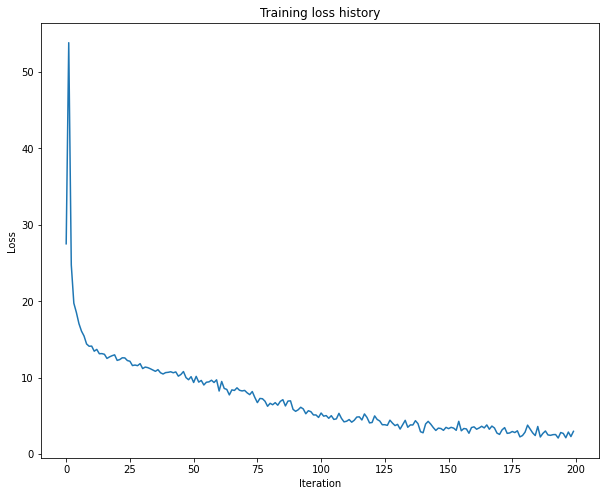

In [65]:
# monitor the training loss
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-3]:
  print('lr: ', lr)
  rpn = RPN()
  RPNSolver(rpn, small_train_loader, learning_rate=lr, num_epochs=200)

## RPN - Inference
We will now visualize the predicted boxes from the RPN that we overfit to a small training sample. We will reuse the `DetectionInference` function from the previous notebook.

In [66]:
def DetectionInference(detector, data_loader, dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, output_dir=None):

  # ship model to GPU
  detector.to(**to_float_cuda)
 
  detector.eval()
  start_t = time.time()

  if output_dir is not None:
    det_dir = 'mAP/input/detection-results'
    gt_dir = 'mAP/input/ground-truth'
    if os.path.exists(det_dir):
      shutil.rmtree(det_dir)
    os.mkdir(det_dir)
    if os.path.exists(gt_dir):
      shutil.rmtree(gt_dir)
    os.mkdir(gt_dir)

  for iter_num, data_batch in enumerate(data_loader):
    images, boxes, w_batch, h_batch, img_ids = data_batch
    images = images.to(**to_float_cuda)

    final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

    # clamp on the proposal coordinates
    batch_size = len(images)
    for idx in range(batch_size):
      torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=w_batch[idx])
      torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=h_batch[idx])

      # visualization
      # get the original image
      # hack to get the original image so we don't have to load from local again...
      i = batch_size*iter_num + idx
      img, _ = dataset.__getitem__(i)

      valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])
      final_all = torch.cat((final_proposals[idx], \
        final_class[idx].float(), final_conf_scores[idx]), dim=-1).cpu()
      resized_proposals = coord_trans(final_all, w_batch[idx], h_batch[idx])

      # write results to file for evaluation (use mAP API https://github.com/Cartucho/mAP for now...)
      if output_dir is not None:
        file_name = img_ids[idx].replace('.jpg', '.txt')
        with open(os.path.join(det_dir, file_name), 'w') as f_det, \
          open(os.path.join(gt_dir, file_name), 'w') as f_gt:
          print('{}: {} GT bboxes and {} proposals'.format(img_ids[idx], valid_box, resized_proposals.shape[0]))
          for b in boxes[idx][:valid_box]:
            f_gt.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[0], b[1], b[2], b[3]))
          for b in resized_proposals:
            f_det.write('{} {:.6f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[5], b[0], b[1], b[2], b[3]))
      else:
        data_visualizer(img, idx_to_class, boxes[idx][:valid_box], resized_proposals)

  end_t = time.time()
  print('Total inference time: {:.1f}s'.format(end_t-start_t))

In [67]:
RPNInference = DetectionInference

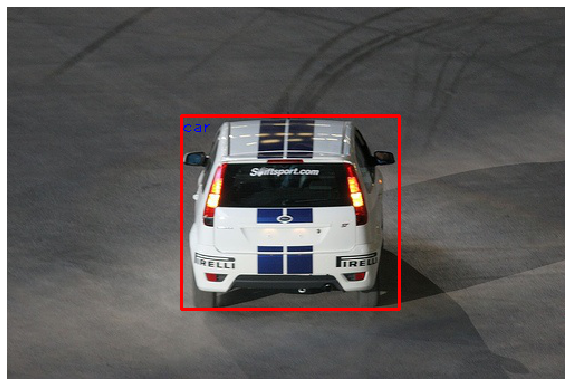

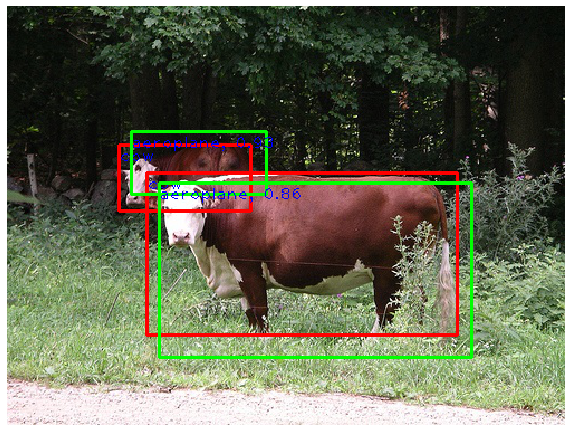

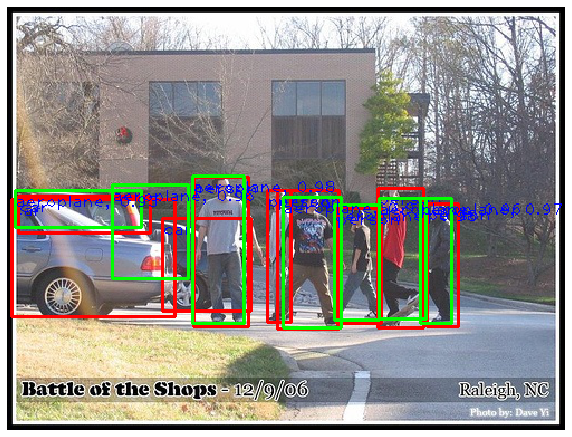

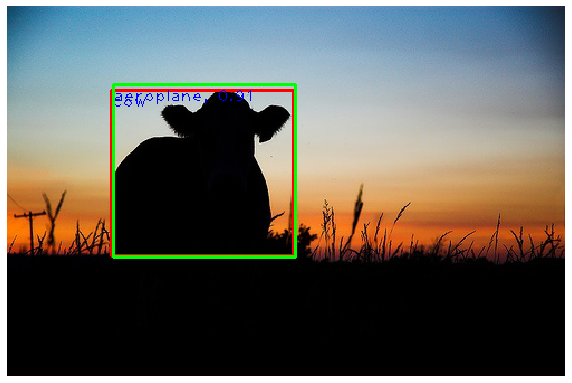

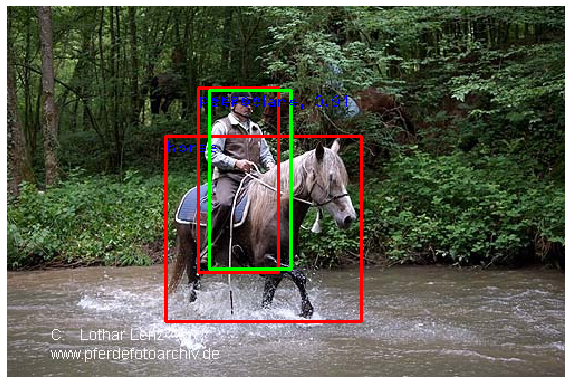

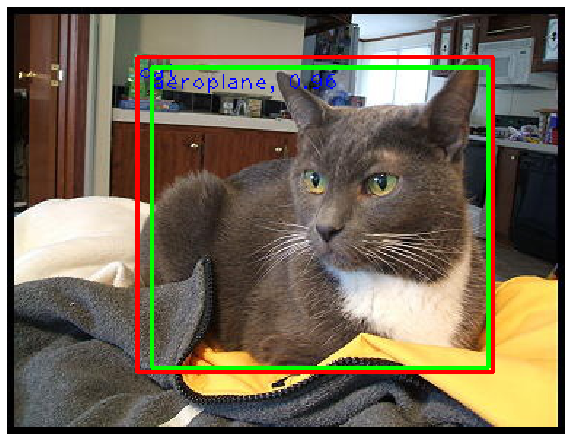

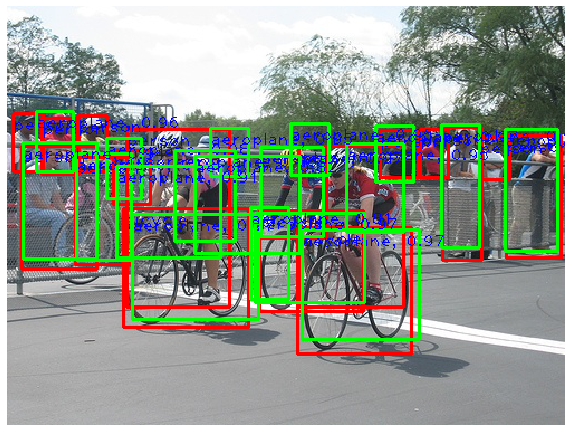

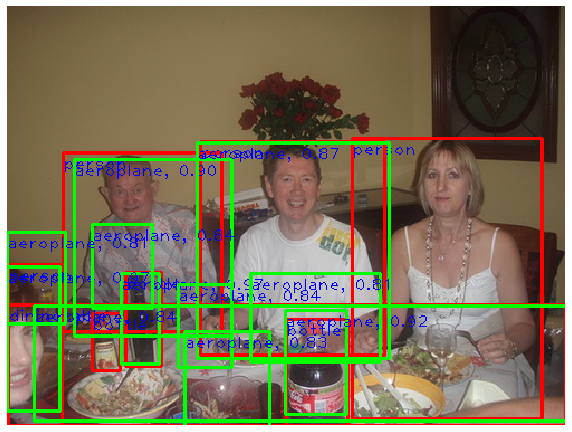

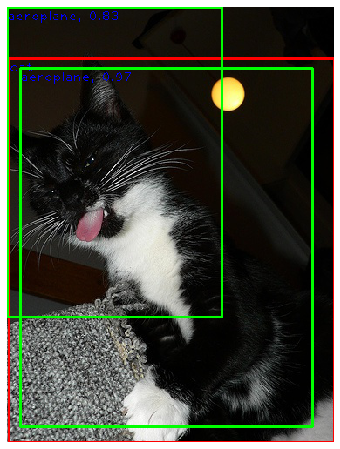

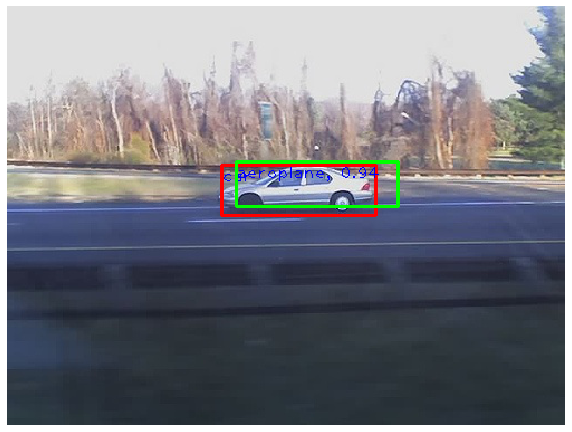

Total inference time: 2.1s


In [68]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
# ignore the dummy object class (in blue) as RPN does not output class!
RPNInference(rpn, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3)

# Faster R-CNN
We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half Fast R-CNN.

Given the proposals or region of interests (RoI) from RPN, we warp each region from CNN activation map to a fixed size 2x2 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf). Essentially, the RoI feature is determined by bilinear interpolation over the CNN activation map. We meanpool the RoI feature over the spatial dimension (2x2).

Finally, we classify the meanpooled RoI feature into class probabilities.

For simplicity, our two-stage detector here differs from a full Faster R-CNN system in a few aspects.
1. In a full implementation, the second stage of the network would predict a second set of offsets to transform the region proposal into a final predicted object bounding box. However we omit this for simplicity.
2. In a full implementation, the second stage of the network should be able to reject negative boxes -- in other words, if we want to predict C different object categories then the final classification layer of the second stage would predict a distribution over C+1 categories, with an extra one for background. We omit this, as it requires extra bookeeping in the second stage about which proposals are positive / negative; so for simplicity our second stage will only predict a distribution over C categories, and we will assume that the RPN has filtered out all background regions.

## RoI Align
We will use the `roi_align` function from `torchvision`. Usage see https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.roi_align

## Faster R-CNN

In [77]:
class TwoStageDetector(nn.Module):
  def __init__(self, in_dim=1280, hidden_dim=256, num_classes=20, \
               roi_output_w=2, roi_output_h=2, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0)
    self.num_classes = num_classes
    self.roi_output_w, self.roi_output_h = roi_output_w, roi_output_h
    ##############################################################################
    # TODO: Declare your RPN and the region classification layer (in Fast R-CNN).#
    # The region classification layer is a sequential module with a Linear layer,#
    # followed by a Dropout (p=drop_ratio), a ReLU nonlinearity and another      #
    # Linear layer that predicts classification scores for each proposal.        #
    # HINT: The dimension of the two Linear layers are in_dim -> hidden_dim and  #
    # hidden_dim -> num_classes.                                                 #
    ##############################################################################
    # Replace "pass" statement with your code
    self.rpn = RPN() 
    self.classification = nn.Sequential(
        nn.Linear(in_dim,hidden_dim), 
        nn.Dropout(p=drop_ratio), 
        nn.ReLU(),
        nn.Linear(hidden_dim,num_classes),  
    )
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, images, bboxes):
    """
    Training-time forward pass for our two-stage Faster R-CNN detector.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - bboxes: Tensor of shape (B, N, 5) giving ground-truth bounding boxes
      and category labels, from the dataloader.

    Outputs:
    - total_loss: Torch scalar giving the overall training loss.
    """
    total_loss = None
    ##############################################################################
    # TODO: Implement the forward pass of TwoStageDetector.                      #
    # A few key steps are outlined as follows:                                   #
    # i) RPN, including image feature extraction, grid/anchor/proposal           #
    #       generation, activated and negative anchors determination.            #
    # ii) Perform RoI Align on proposals and meanpool the feature in the spatial #
    #     dimension.                                                             #
    # iii) Pass the RoI feature through the region classification layer which    #
    #      gives the class probilities.                                          #
    # iv) Compute class_prob through the prediction network and compute the      #
    #     cross entropy loss (cls_loss) between the prediction class_prob and    #
    #      the reference GT_class. Hint: Use F.cross_entropy loss.               #
    # v) Compute the total_loss which is formulated as:                          #
    #    total_loss = rpn_loss + cls_loss.                                       #
    ##############################################################################
    # Replace "pass" statement with your code
    batch_size = images.shape[0]
    rpn_total_loss, conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img = self.rpn(images, bboxes,'all')
    
    batch_index = (pos_anchor_idx // anc_per_img).unsqueeze(1).to(proposals.dtype)# range is from 0-9
    proposals_w_batch_index = torch.cat((batch_index,proposals),dim=1) #[50,5]
    print(features,proposals_w_batch_index)
    aligned_features = torchvision.ops.roi_align(features, proposals_w_batch_index, 
                                                 (self.roi_output_w, self.roi_output_h)) 
    #aligned_features: M,Channel,2,2
    # meanpool
    pooled_features = torch.mean(aligned_features,(2,3))

    # Pass the RoI feature through the region classification layer
    cls_scores = self.classificationLayer(pooled_features)
    cls_loss = F.cross_entropy(cls_scores, GT_class, reduction='sum') * 1. / batch_size #This will boot performance by 2%

    total_loss = cls_loss + rpn_total_loss

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return total_loss

  def inference(self, images, thresh=0.5, nms_thresh=0.7):
    """"
    Inference-time forward pass for our two-stage Faster R-CNN detector

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - thresh: Threshold value on NMS object probabilities
    - nms_thresh: IoU threshold for NMS in the RPN

    We can output a variable number of predicted boxes per input image.
    In particular we assume that the input images[i] gives rise to P_i final
    predicted boxes.

    Outputs:
    - final_proposals: List of length (B,) where final_proposals[i] is a Tensor
      of shape (P_i, 4) giving the coordinates of the final predicted boxes for
      the input images[i]
    - final_conf_probs: List of length (B,) where final_conf_probs[i] is a
      Tensor of shape (P_i,) giving the predicted probabilites that the boxes
      in final_proposals[i] are objects (vs background)
    - final_class: List of length (B,), where final_class[i] is an int64 Tensor
      of shape (P_i,) giving the predicted category labels for each box in
      final_proposals[i].
    """
    final_proposals, final_conf_probs, final_class = None, None, None
    ##############################################################################
    # TODO: Predicting the final proposal coordinates `final_proposals`,        #
    # confidence scores `final_conf_probs`, and the class index `final_class`.  #
    # The overall steps are similar to the forward pass but now you do not need #
    # to decide the activated nor negative anchors.                             #
    # HINT: Use the RPN inference function to perform thresholding and NMS, and #
    # to compute final_proposals and final_conf_probs. Use the predicted class  #
    # probabilities from the second-stage network to compute final_class.       #
    ##############################################################################
    # Replace "pass" statement with your code
    final_proposals, final_conf_probs, features = self.rpn.inference(images, thresh,nms_thresh,mode='FasterRCNN')
    print(final_proposals,final_conf_probs,features)
    aligned_features = torchvision.ops.roi_align(features, final_proposals, (self.roi_output_w, self.roi_output_h)) 
    pooled_feats = torch.mean(aligned_features,(2,3))
    cls_scores = self.classification(pooled_feats)
    cls_max = torch.max(cls_scores,dim=1)[1].to(torch.int64).unsqueeze(1)
    cnt = 0 
    for i in range(len(final_proposals)):
      length_cur = len(final_proposals[i])
      final_class.append(cls_max[cnt:cnt+length_cur])
      cnt += length_cur
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return final_proposals, final_conf_probs, final_class

## Overfit small data
We will now overfit the full Faster R-CNN network on a small subset of the training data. After training you should see a final loss less than 4.0.

In [78]:
# monitor the training loss

lr = 1e-3
detector = TwoStageDetector()
DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200)

number of pos proposals:  50
None tensor([[ 0.0000,  1.6801,  2.5003,  6.1635,  6.9462],
        [ 1.0000,  3.3129,  1.5017,  4.2889,  3.4005],
        [ 1.0000, -1.3245,  1.4156,  9.5700,  6.5618],
        [ 1.0000, -0.4817,  3.7272,  7.1359,  7.5576],
        [ 2.0000,  0.1533,  3.2991,  1.5228,  4.2076],
        [ 2.0000,  1.4601,  3.5967,  2.8035,  4.5267],
        [ 2.0000,  2.1265,  4.7304,  3.3711,  5.3933],
        [ 2.0000,  3.0939,  4.4689,  4.4412,  5.6788],
        [ 2.0000,  4.2033,  3.9828,  5.3811,  5.4271],
        [ 2.0000,  4.5627,  4.4158,  6.2708,  5.5757],
        [ 2.0000,  2.2314,  3.4960,  3.1764,  5.7865],
        [ 2.0000,  2.6987,  3.7791,  4.9927,  5.4788],
        [ 2.0000,  3.7516,  3.7087,  5.4061,  5.6126],
        [ 2.0000, -1.2391,  4.8738,  1.6179,  6.4583],
        [ 3.0000,  0.1453,  1.8975,  2.3729,  4.5631],
        [ 4.0000,  0.4103,  2.7095,  5.6477,  5.0136],
        [ 4.0000,  1.3002,  4.2219,  2.4212,  6.2655],
        [ 5.0000,  3.7752, -0.8

RuntimeError: ignored

### Inference

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3)

## Train a net
Now it's time to train the full Faster R-CNN model on a larger subset of the the training data. We will train for 50 epochs; this should take about 35 minutes on a K80 GPU. You should see a total loss less than 3.0.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, 100) # a new loader

num_epochs = 50
lr = 5e-3
frcnn_detector = TwoStageDetector()
DetectionSolver(frcnn_detector, train_loader, learning_rate=lr, num_epochs=num_epochs)

### Inference

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(frcnn_detector, small_train_loader, small_dataset, idx_to_class)

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 16% or above.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
!rm -r mAP/input/*
DetectionInference(frcnn_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3)
# DetectionInference(frcnn_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3) # uncomment to see training mAP
!cd mAP && python main.py